# Here in Amazon Mobile DataSet we have TEXT data

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [3]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

{'under', 'having', 'aren', 'their', 'them', "that'll", 'than', 'yours', 'over', 'about', 'that', 'wouldn', 'had', 'again', 'herself', 'any', 'own', 'very', 'm', 'out', "haven't", "wasn't", 'my', 'themselves', 'of', 'ain', 'myself', 'by', "shan't", 'when', 'between', 'they', 'if', 'won', 'for', 'theirs', 'such', 'further', 'shouldn', 'we', 'don', "needn't", "you'll", 'i', 'up', 'be', 'can', 'what', 'why', "you'd", 'did', 'just', 'hasn', "you've", 'from', 'is', 'few', "hadn't", 'he', 'this', 'until', 'into', 'should', 'have', "didn't", 'him', 'a', 'no', 'after', 's', 'once', 'whom', 'down', 'nor', 'weren', 'who', 'through', 'during', 'you', 'll', 'before', 'mightn', 'doing', 'o', 'more', 'to', 't', 'all', "won't", 'hadn', 'these', 'am', 'in', 'your', 'shan', 'itself', "wouldn't", 'other', 'or', 'each', 'off', 'most', 'y', 'the', "don't", 'doesn', "hasn't", 're', "you're", 'hers', 'does', 'has', "doesn't", 'there', 'ours', 'yourselves', 'above', 'she', 'isn', 'needn', 'himself', 'how', '

In [4]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows=5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

# Divide data to raining and testing
from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


# Data PreProcessing - Bag Of Words

In [5]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

After vectorizations
(4000, 2814)
(1000, 2814)
(4000,)
(1000,)
...............................


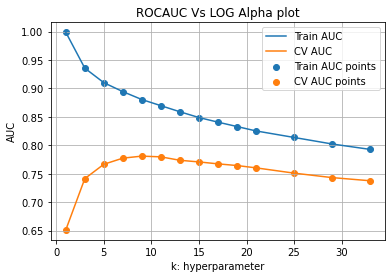

{'n_neighbors': 9}
0.7810412554665428


In [6]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # K values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best k value
print(clf.best_score_)



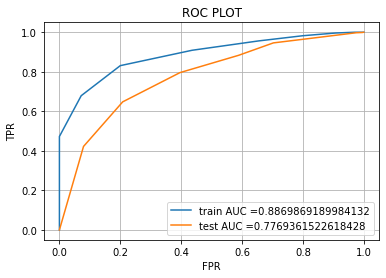

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.6648275862068966 for threshold 0.778
Train confusion matrix


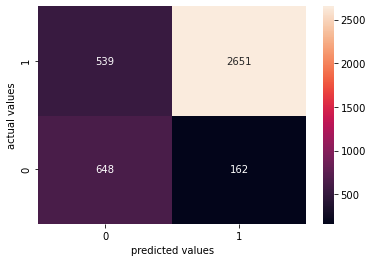

Test confusion matrix


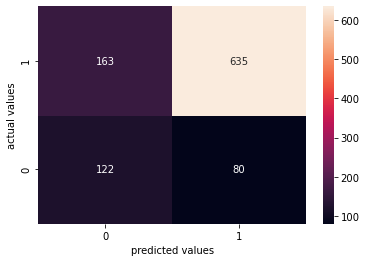

In [8]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

# Data PreProcessing - TFIDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer# TFIDF convertion

tfvec = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfvec.fit(inputtrain['j'].values)

tfidf_train_cleanedtext = tfvec.transform(inputtrain['j'].values)
tfidf_test_cleanedtext= tfvec.transform(inputtest['j'].values)

print("After vectorizations")
print(tfidf_train_cleanedtext.shape)
print(tfidf_test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")


After vectorizations
(4000, 2814)
(1000, 2814)
(4000,)
(1000,)
...............................


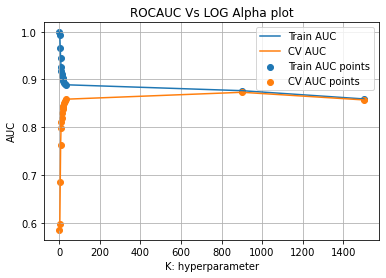

{'n_neighbors': 901}
0.8731336352026009


In [10]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33,901,1501]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(tfidf_train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



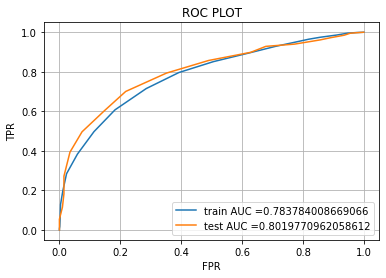

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.5111262045744804 for threshold 0.877
Train confusion matrix


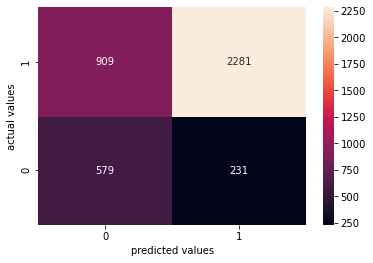

Test confusion matrix


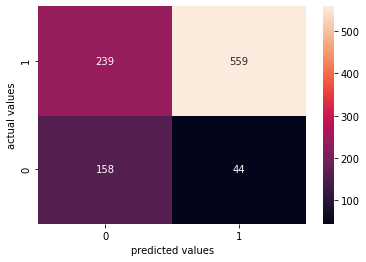

In [11]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=901)
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(tfidf_train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(tfidf_test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

# Data PreProcessing - Avg Word2Vec

In [12]:
#AVG word2vec
from gensim.models import Word2Vec
import gensim

train_list=[]
for sent in inputtrain['j']:
    train_list.append(sent.split(' '))
# min_count = 10 i.e Each word must occur atleat 10 times in any of the documents in Document corpus
# NOTE: Only Training Document corpus Words converted to Vector of 50 dimentions
w2vmodel= gensim.models.Word2Vec(train_list,min_count=10,size=50,workers=4) 
print(w2vmodel.wv.most_similar('great'))


input_train_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (inputtrain['j'].values): # for each review/sentence
    sentvec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    countwords =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vmodel:
            vec = w2vmodel.wv[word]
            sentvec += vec
            countwords += 1
    if countwords != 0:
        sentvec /= countwords
    input_train_w2v.append(sentvec)
print('Total no of Training Documents or Total no of Avg Word2Vec Vectors :',len(input_train_w2v))
print('Avg Word2Vec Vector dimention of Each Training document: ',len(input_train_w2v[0]))

#min_count = 10 i.e Each word must occur atleat 10 times in any of the documents in Document corpus
#NOTE: Training Document corpus Words converted to Vector(50 dimention) 
# Each Words in a document is 50 dimention Vector
# Take Average of Each of Words in document(Avg Word2Vec Vector of 50 dim for this document).  
# Find Avg Word2Vec Vector of 50 dim for each of documents in Document corpus
# Lets take we have 4000 Training Documents, then o/p(Avg 50 dim vector of all the 4000 training documents) will be of size (4000,50)
# Lets take we have 1000 Testing Documents, then o/p(Avg 50 dim vector of all the 1000 testing documents) will be of size (1000,50)

input_test_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (inputtest['j'].values): # for each review/sentence
    sentvec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    countwords =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vmodel:
            vec = w2vmodel.wv[word]
            sentvec += vec
            countwords += 1
    if countwords != 0:
        sentvec /= countwords
    input_test_w2v.append(sentvec)
print('Total no of Testing Documents or Total no of Avg Word2Vec Vectors :',len(input_test_w2v))
print('Avg Word2Vec Vector dimention of Each Testing document: ',len(input_test_w2v[0]))
print('1st Testing document Avg Word2Vec Vector :',input_test_w2v[0])

[('good', 0.9791978001594543), ('look', 0.969054102897644), ('fast', 0.9660190343856812), ('high', 0.9622178077697754), ('realli', 0.9576595425605774), ('nice', 0.9552852511405945), ('feel', 0.9535080194473267), ('well', 0.951924204826355), ('excel', 0.9509830474853516), ('amaz', 0.9480682015419006)]


<ipython-input-12-aad61eb51ade>:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in w2vmodel:


Total no of Training Documents or Total no of Avg Word2Vec Vectors : 4000
Avg Word2Vec Vector dimention of Each Training document:  50


<ipython-input-12-aad61eb51ade>:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in w2vmodel:


Total no of Testing Documents or Total no of Avg Word2Vec Vectors : 1000
Avg Word2Vec Vector dimention of Each Testing document:  50
1st Testing document Avg Word2Vec Vector : [ 0.08757996  0.16210009 -0.19899551  0.09727298  0.0291038  -0.17292844
 -0.2195045  -0.3493582   0.18997619 -0.33966445  0.09552392  0.32230836
  0.1333821   0.0263506  -0.20623873  0.00908963 -0.22463331  0.03777743
 -0.25005594 -0.14732542  0.01583315  0.32357496  0.05206288 -0.09733908
  0.34772969 -0.03286276  0.02866895  0.1853259  -0.15192648 -0.07618171
  0.28921831 -0.05334543 -0.02098221  0.14957025 -0.04370432  0.14061594
  0.04163915 -0.03967156  0.08126398  0.1108826  -0.22312011 -0.010152
 -0.06027604 -0.22119208 -0.14962108  0.2336217  -0.2274412   0.09228499
  0.0131173   0.19494098]


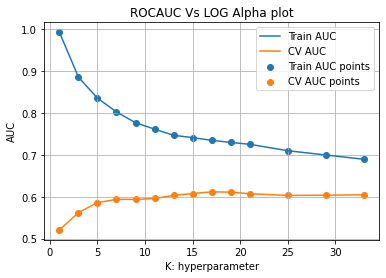

{'n_neighbors': 17}
0.6117351677696506


In [13]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(input_train_w2v, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



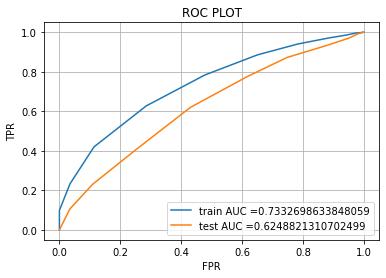

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.4483838383838384 for threshold 0.824
Train confusion matrix


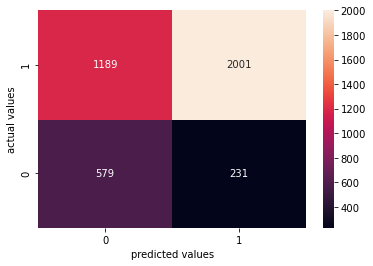

Test confusion matrix


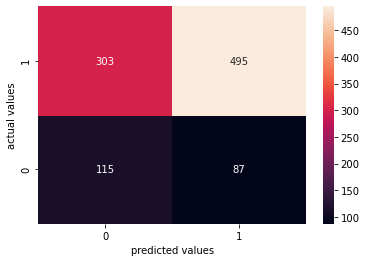

In [14]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=17)
neigh.fit(input_train_w2v, outputtrain)



y_train_pred = neigh.predict_proba(input_train_w2v)[:,1]    
y_test_pred = neigh.predict_proba(input_test_w2v)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

# Data PreProcessing - TFIDF Word2Vec

In [15]:
#TFIDF word2vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

tfvec = TfidfVectorizer(min_df=10)
tfvec.fit(inputtrain['j'].values)


train_list=[]
for sent in inputtrain['j']:
    train_list.append(sent.split(' '))
w2vmodel= gensim.models.Word2Vec(train_list,min_count=10,size=50,workers=4)


dictionary = dict(zip(tfvec.get_feature_names(), list(tfvec.idf_)))

tfidf_feat = tfvec.get_feature_names() 
w2v_feat=list(w2vmodel.wv.vocab)

train_sentence_list=[]
for sent in inputtrain['j']:
    train_sentence_list.append(sent.split(' '))

tfidf_train_vectors = []; 
row=0
for sent in (train_sentence_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2vmodel and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(row)



test_sentence_list=[]
for sent in inputtest['j']:
    test_sentence_list.append(sent.split(' '))

tfidf_test_vectors = []; 
row=0
for sent in (test_sentence_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2vmodel and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(row)



<ipython-input-15-ba61fafac29f>:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in w2vmodel and word in tfidf_feat:


4000


<ipython-input-15-ba61fafac29f>:58: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in w2vmodel and word in tfidf_feat:


1000


In [16]:
print(tfidf_train_vectors)


[array([ 0.17372288,  0.33797774, -0.33774914,  0.21007318, -0.05374955,
       -0.34749378, -0.39612785, -0.61265986,  0.40317418, -0.67639402,
        0.07704634,  0.46437701,  0.24355856,  0.05535177, -0.34596068,
        0.1536988 , -0.44554168,  0.08979824, -0.4747492 , -0.18031386,
        0.03113818,  0.55919305,  0.17372891, -0.08421617,  0.57496421,
       -0.01792306, -0.0152451 ,  0.25580144, -0.30558647, -0.20474648,
        0.43862821, -0.13996711,  0.02685223,  0.24331584, -0.2616971 ,
        0.31611578,  0.0317336 , -0.11570279,  0.08312302,  0.13233659,
       -0.46008337, -0.12702104, -0.1195339 , -0.4020404 , -0.19930312,
        0.45448031, -0.45911148,  0.05749489,  0.08402964,  0.44115529]), array([ 2.20462579e-01,  3.04205721e-01, -3.17346018e-01,  1.65853851e-01,
        1.95881218e-03, -2.98190820e-01, -4.34895738e-01, -6.09365623e-01,
        3.58126382e-01, -5.81250562e-01,  1.66043771e-01,  5.56733382e-01,
        2.15972568e-01,  5.35683155e-02, -3.54451984

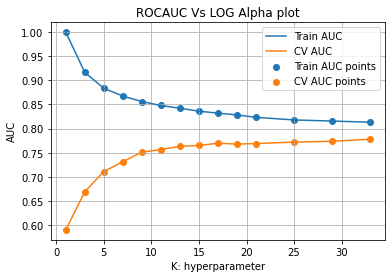

{'n_neighbors': 33}
0.778011919965943


In [17]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(tfidf_train_vectors, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



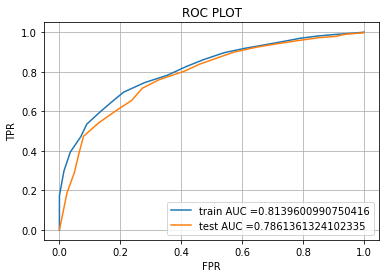

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.5499965168930686 for threshold 0.788
Train confusion matrix


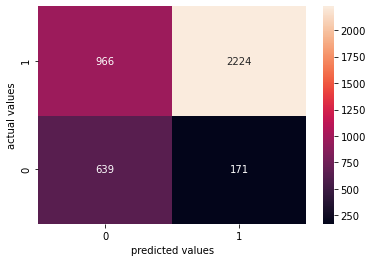

Test confusion matrix


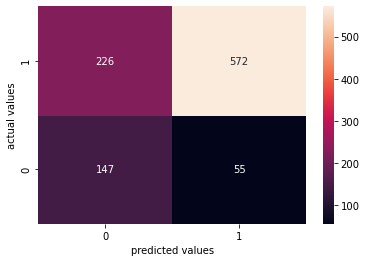

In [18]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=33)
neigh.fit(tfidf_train_vectors, outputtrain)



y_train_pred = neigh.predict_proba(tfidf_train_vectors)[:,1]    
y_test_pred = neigh.predict_proba(tfidf_test_vectors)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()